#**FinAI-BERT-IslamicBanks Model Training**

In [1]:
# 1. Install and upgrade dependencies
!pip install -U transformers datasets scikit-learn tqdm --quiet

# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# 4. Load your data
file_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/bert_training_data.csv"
df = pd.read_csv(file_path)
print(f"✅ Loaded {len(df)} rows: {df.columns.tolist()}")
print(df.head())

# 5. Train/Test split
train_df, test_df = train_test_split(df[['sentence', 'label']], test_size=0.2, stratify=df['label'], random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

# 6. Tokenization (with progress)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch): return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)
print("Tokenizing train...")
train_ds = train_ds.map(tokenize, batched=True, batch_size=256, desc="Tokenizing train")
print("Tokenizing test...")
test_ds = test_ds.map(tokenize, batched=True, batch_size=256, desc="Tokenizing test")
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 7. Load BERT for classification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 8. Training arguments (use `eval_strategy` for HF>=4.46)
training_args = TrainingArguments(
    output_dir="/content/bert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="/content/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy="steps",
    save_total_limit=2,
    report_to="none"
)

# 9. Compute metrics function
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

# 10. Trainer & training (progress auto-logged)
print("🚀 Training starting...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()
print("✅ Training complete.")

# 11. Evaluate & Save
print("📊 Final evaluation on test set:")
eval_result = trainer.evaluate()
print(eval_result)
save_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/FinAI-BERT-IslamicBanks"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"💾 Model saved to: {save_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_ma

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing train...


Tokenizing train:   0%|          | 0/2105 [00:00<?, ? examples/s]

Tokenizing test...


Tokenizing test:   0%|          | 0/527 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-2951978839.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training starting...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.005200,0.141955,0.977230,0.977612
2,0.034800,0.065036,0.986717,0.986817
3,0.000600,0.078044,0.986717,0.986817


✅ Training complete.
📊 Final evaluation on test set:


{'eval_loss': 0.06503608822822571, 'eval_accuracy': 0.9867172675521821, 'eval_f1': 0.9868173258003766, 'eval_runtime': 4.2196, 'eval_samples_per_second': 124.894, 'eval_steps_per_second': 15.641, 'epoch': 3.0}
💾 Model saved to: /content/drive/My Drive/FinAI-BERT-IslamicBanks/FinAI-BERT-IslamicBanks


#**Model Evaluation**

📊 Classification Report:
              precision    recall  f1-score   support

      Non-AI       1.00      1.00      1.00       263
          AI       1.00      1.00      1.00       264

    accuracy                           1.00       527
   macro avg       1.00      1.00      1.00       527
weighted avg       1.00      1.00      1.00       527



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


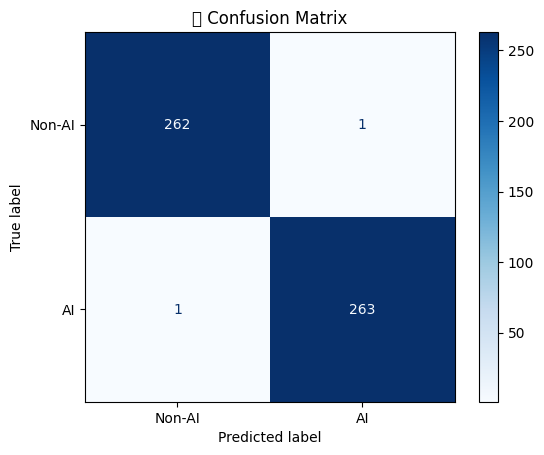

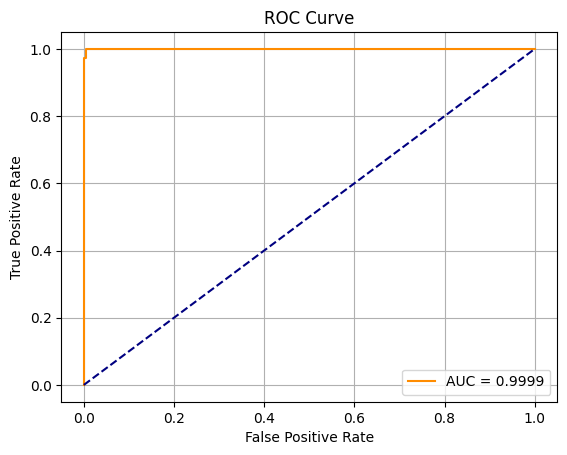

✅ ROC AUC Score: 0.9999

❌ False Positives (Non-AI predicted as AI):
 - 41 In 2018, a number of innovative projects and initiatives have been launched, such as the project of Integrated Data Management Solution for bank wide use which is being implemented to allow KIB to host a fully managed solution; the launch of "Chat" service for smartphones/online; the completion of the NFC payment service (Near Field Communication); rationalization and re-distribution of retail network and spread of the Bank's branch network to reach the largest possible segment of customers; Finalized designs of the branches by contracting an international top notch design firm; the improvement of omnichannel services to provide enhanced digital banking experience via internet and the improved smartphone application, utilizing the latest technology available, the matter which attracted new segment of customers, and resulted in a better growth of depositors' accounts, especially Arzaq and Al Boushra deposits.

❌ 

In [4]:
# 1️⃣ Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2️⃣ Load model & tokenizer
model_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/FinAI-BERT-IslamicBanks"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# 3️⃣ Load and prepare test data
data_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/bert_training_data.csv"
df = pd.read_csv(data_path).drop_duplicates(subset="sentence")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4️⃣ Stratified test set (20%)
from sklearn.model_selection import train_test_split
_, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# 5️⃣ Prediction function
def predict_sentences(sentences, batch_size=64):
    preds, probs = [], []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            prob = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
            preds += list(np.argmax(prob, axis=1))
            probs += list(prob[:, 1])  # AI class score
    return np.array(preds), np.array(probs)

# 6️⃣ Predict and evaluate
y_true = test_df["label"].values
y_pred, y_prob = predict_sentences(test_df["sentence"].tolist())

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-AI", "AI"]))

# 7️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-AI", "AI"]).plot(cmap="Blues")
plt.title("🧾 Confusion Matrix")
plt.grid(False)
plt.show()

# 8️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
print(f"✅ ROC AUC Score: {roc_auc:.4f}")

# 9️⃣ View misclassified examples
print("\n❌ False Positives (Non-AI predicted as AI):")
for s in test_df[(y_true == 0) & (y_pred == 1)]["sentence"].head(5):
    print(" -", s)

print("\n❌ False Negatives (AI predicted as Non-AI):")
for s in test_df[(y_true == 1) & (y_pred == 0)]["sentence"].head(5):
    print(" -", s)


#**Calibration Test using the Brier Score**

In [6]:
from sklearn.metrics import brier_score_loss

# You already have:
# y_true → true labels (0 or 1)
# y_prob → predicted probability for class 1 (AI)

# Compute Brier Score
brier_score = brier_score_loss(y_true, y_prob)

print(f"📏 Brier Score: {brier_score:.4f}")

# Optional interpretation
if brier_score < 0.05:
    interpretation = "Excellent calibration"
elif brier_score < 0.10:
    interpretation = "Good calibration"
elif brier_score < 0.20:
    interpretation = "Moderate calibration"
else:
    interpretation = "Poor calibration"

print(f"🧠 Interpretation: {interpretation}")

📏 Brier Score: 0.0027
🧠 Interpretation: Excellent calibration


#**Test the Model**

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# === Load model & tokenizer ===
model_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/FinAI-BERT-IslamicBanks"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Input random sentences ===
sentences = [
    "The bank deployed machine learning algorithms to improve credit scoring.",
    "Our capital adequacy ratio increased by 1.2% this year.",
    "We introduced a customer service chatbot powered by generative AI.",
    "The Board of Directors met quarterly to review audit reports.",
    "An AI-driven fraud detection system was implemented in 2022."
]

# === Predict ===
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# === Format results ===
results = []
for sent, prob in zip(sentences, probs):
    label = "AI" if prob[1] > 0.5 else "Non-AI"
    score = round(prob[1], 4)  # probability of AI class
    results.append((sent, label, score))

# === Display as DataFrame ===
df = pd.DataFrame(results, columns=["Sentence", "Prediction", "Score"])
print(df)


                                            Sentence Prediction   Score
0  The bank deployed machine learning algorithms ...         AI  0.9995
1  Our capital adequacy ratio increased by 1.2% t...     Non-AI  0.0015
2  We introduced a customer service chatbot power...         AI  0.9997
3  The Board of Directors met quarterly to review...     Non-AI  0.0011
4  An AI-driven fraud detection system was implem...         AI  0.9996


#**Evaluation of Model Stability Across Input Variants**

In [8]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# === Load FinAI-BERT Model ===
model_path = "/content/drive/My Drive/FinAI-BERT-IslamicBanks/FinAI-BERT-IslamicBanks"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Define Test Cases (10 per category) ===
robust_tests = {
    "Edge Cases": [
        ("We enhanced digital infrastructure and monitoring systems.", 0),
        ("Predictive tools were discussed in our IT committee.", 1),
        ("Data pipeline transformation was prioritized.", 0),
        ("AI-inspired analytics are under evaluation.", 1),
        ("Automation was aligned with compliance reporting.", 0),
        ("Machine learning prototypes were presented for board review.", 1),
        ("Digital solutions were explored to enhance efficiency.", 0),
        ("Risk-based modeling was mentioned in the audit report.", 0),
        ("Smart technologies are being studied.", 1),
        ("The IT strategy referenced data automation.", 1)
    ],
    "Noise-Injected": [
        ("Intelligent systems!!! were integrated?????", 1),
        ("We aplied robotic--process--automation in audit.", 1),
        ("Upgraded systems. Optimised. Efficiency. Done.", 0),
        ("Deployd AI driven solutins", 1),
        ("The framework,,, includes automation.", 0),
        ("Autonomous tech was, uh, kinda like... used.", 1),
        ("Digital--infra--enhanced!", 0),
        ("Ml & Ai r in ops now", 1),
        ("Somewhere, somehow, AI?", 0),
        ("By the way, robot stuff is there.", 1)
    ],
    "Translated": [
        ("Artificial intelligence was introduced in operations.", 1),
        ("An advanced system for risk prediction has been applied.", 1),
        ("Customer support is now assisted by smart tools.", 1),
        ("Technology upgrades support the new services.", 0),
        ("Digital transformation drives our future plan.", 0),
        ("Automation tools are now integral to decision-making.", 1),
        ("Modern AI methods have been implemented recently.", 1),
        ("Risk was reduced using machine intelligence.", 1),
        ("New systems help teams stay productive.", 0),
        ("Innovation fosters better service delivery.", 0)
    ],
    "Syntactically Altered": [
        ("Into our audit functions, we embedded artificial intelligence.", 1),
        ("The bank introduced automation this year.", 1),
        ("The team improved compliance through tech use.", 0),
        ("AI is being reviewed by the board committee.", 1),
        ("Banking workflows were optimized using digital tools.", 0),
        ("Across departments, intelligent automation was tested.", 1),
        ("We reviewed performance via smart dashboards.", 0),
        ("Systems based on machine learning were launched.", 1),
        ("Advanced software now handles applications.", 1),
        ("Customer journey is mapped with tech systems.", 0)
    ]
}

# === Predict Function ===
def predict_with_scores(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1).tolist()
        scores = probs[:, 1].tolist()  # Confidence for AI class
    return preds, scores

# === Evaluation ===
all_results = []

for category, test_cases in robust_tests.items():
    sentences, expected = zip(*test_cases)
    preds, scores = predict_with_scores(sentences)
    for s, e, p, score in zip(sentences, expected, preds, scores):
        all_results.append({
            "Category": category,
            "Sentence": s,
            "Expected": e,
            "Predicted": p,
            "Confidence (AI)": round(score, 3),
            "Correct": int(p == e)
        })

# === Display Results ===
df_results = pd.DataFrame(all_results)
print(df_results.to_string(index=False))

# === Summary Table ===
summary = (
    df_results.groupby("Category")["Correct"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "Correct", "count": "Total"})
)
summary["Accuracy (%)"] = round(100 * summary["Correct"] / summary["Total"], 2)

print("\n📊 Robustness Summary:")
print(summary)


             Category                                                       Sentence  Expected  Predicted  Confidence (AI)  Correct
           Edge Cases     We enhanced digital infrastructure and monitoring systems.         0          0            0.002        1
           Edge Cases           Predictive tools were discussed in our IT committee.         1          0            0.002        0
           Edge Cases                  Data pipeline transformation was prioritized.         0          0            0.002        1
           Edge Cases                    AI-inspired analytics are under evaluation.         1          1            1.000        1
           Edge Cases              Automation was aligned with compliance reporting.         0          0            0.001        1
           Edge Cases   Machine learning prototypes were presented for board review.         1          1            1.000        1
           Edge Cases         Digital solutions were explored to enhance eff

#**Baseline Model Comparison**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
✅ Balanced dataset created:
   - AI sentences: 1316 (deduplicated)
   - Non-AI sentences: 1316 (random sample)
   - Total: 2632

🔍 Evaluating: Logistic Regression
📊 Classification Report:
              precision   

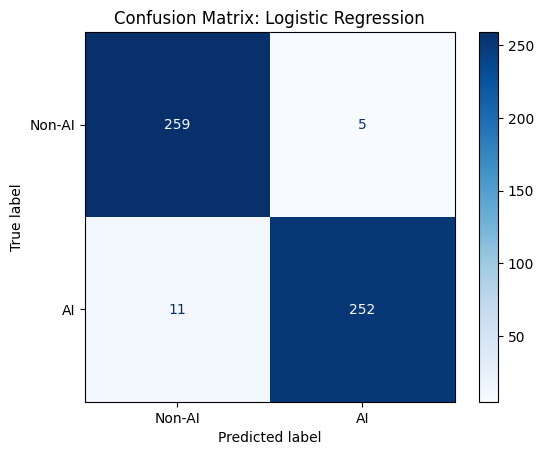


🔍 Evaluating: Naive Bayes
📊 Classification Report:
              precision    recall  f1-score   support

      Non-AI       0.94      0.88      0.91       264
          AI       0.89      0.94      0.92       263

    accuracy                           0.91       527
   macro avg       0.91      0.91      0.91       527
weighted avg       0.91      0.91      0.91       527



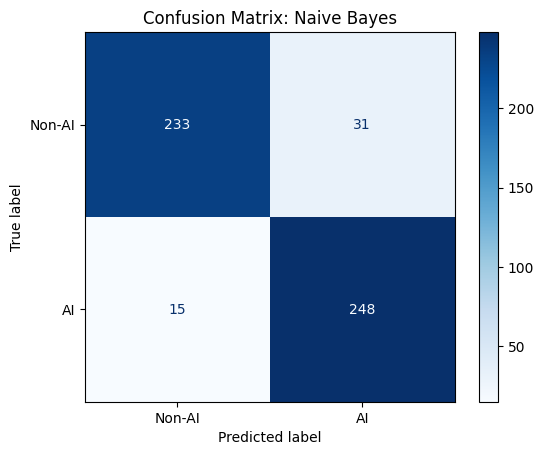


🔍 Evaluating: Random Forest
📊 Classification Report:
              precision    recall  f1-score   support

      Non-AI       0.99      0.99      0.99       264
          AI       0.99      0.99      0.99       263

    accuracy                           0.99       527
   macro avg       0.99      0.99      0.99       527
weighted avg       0.99      0.99      0.99       527



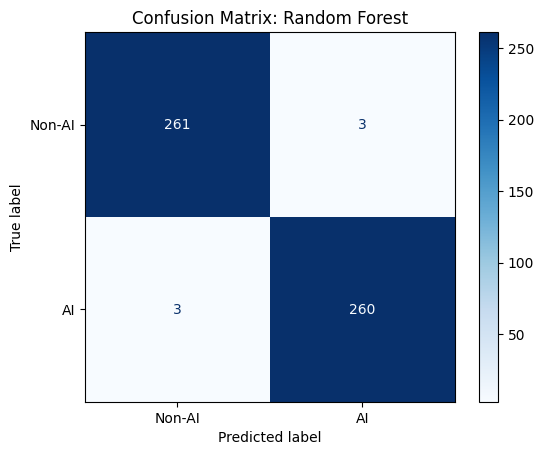


🔍 Evaluating: XGBoost
📊 Classification Report:
              precision    recall  f1-score   support

      Non-AI       0.99      0.98      0.98       264
          AI       0.98      0.99      0.98       263

    accuracy                           0.98       527
   macro avg       0.98      0.98      0.98       527
weighted avg       0.98      0.98      0.98       527



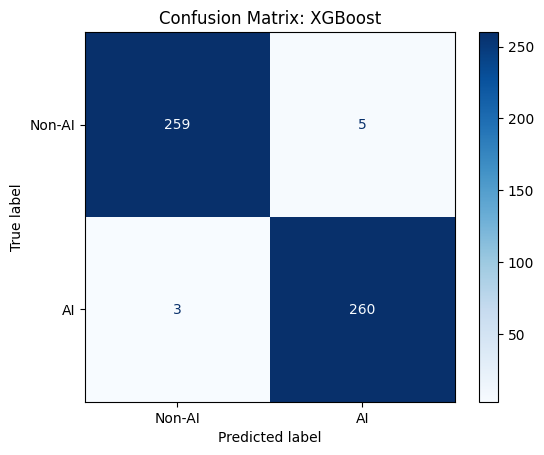

In [9]:
# 1. Install dependencies
!pip install -U scikit-learn pandas matplotlib xgboost --quiet

# 2. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# 3. Load dataset (no global deduplication)
df = pd.read_csv("/content/drive/My Drive/FinAI-BERT-IslamicBanks/bert_training_data.csv")

# 4. Deduplicate only AI sentences
df_ai = df[df['label'] == 1].drop_duplicates(subset='sentence').reset_index(drop=True)

# 5. Randomly sample same number of non-AI (even if duplicates exist)
df_non_ai = df[df['label'] == 0].sample(n=len(df_ai), random_state=42).reset_index(drop=True)

# 6. Combine and shuffle
df_balanced = pd.concat([df_ai, df_non_ai], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Balanced dataset created:")
print(f"   - AI sentences: {len(df_ai)} (deduplicated)")
print(f"   - Non-AI sentences: {len(df_non_ai)} (random sample)")
print(f"   - Total: {len(df_balanced)}")

# 7. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['sentence'], df_balanced['label'],
    test_size=0.2, stratify=df_balanced['label'], random_state=42
)

# 8. TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 9. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# 10. Evaluate models
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Non-AI", "AI"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-AI", "AI"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()


#**Text Length Bias Check**

📏 Evaluating sentence length bias...


Scoring sentences: 100%|██████████| 1950/1950 [02:30<00:00, 12.94it/s]
/tmp/ipython-input-17-37678222.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby("bin")[["length", "score"]].mean().dropna()


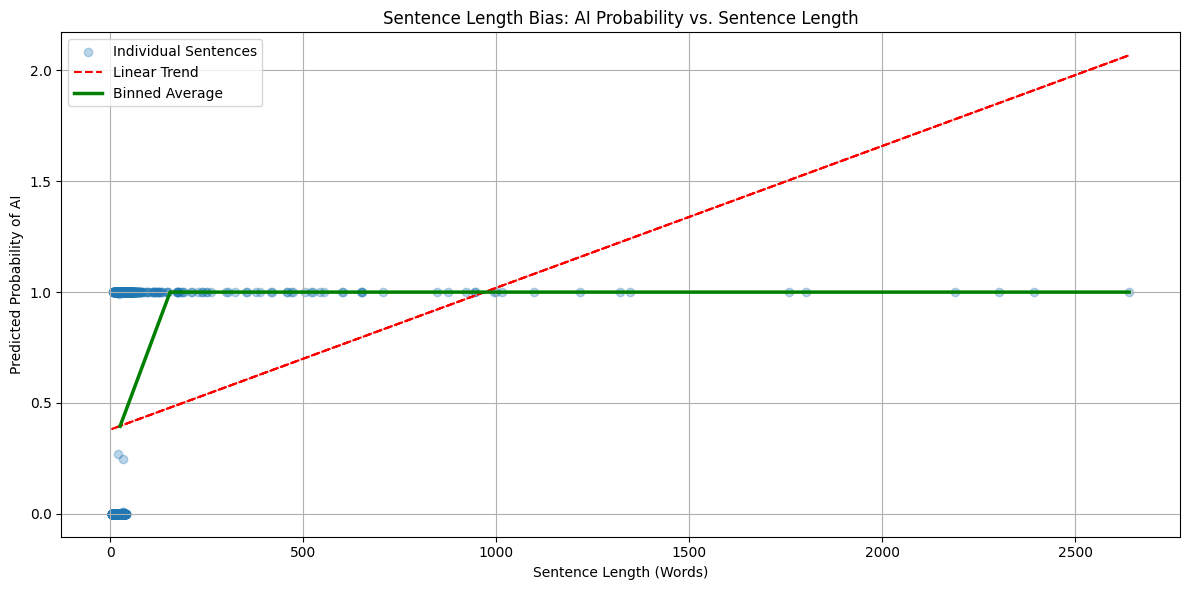

📈 Correlation between sentence length and AI probability: 0.2018


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# === Load model ===
model_path = "/content/drive/My Drive/FinAI-BERT Model Training/FinAI-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Load data (no balancing applied) ===
data_path = "/content/drive/My Drive/FinAI-BERT Model Training/FinAI-BERT training data.csv"
df = pd.read_csv(data_path).drop_duplicates(subset="sentence").reset_index(drop=True)

# === Predict function ===
def get_probabilities(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs[:, 1]  # Probability of class 1 (AI)

# === Process
lengths, probs = [], []

print("📏 Evaluating sentence length bias...")
for sentence in tqdm(df["sentence"], desc="Scoring sentences"):
    length = len(sentence.split())
    prob = get_probabilities([sentence])[0]
    lengths.append(length)
    probs.append(prob)

df["length"] = lengths
df["score"] = probs

# === Plot
plt.figure(figsize=(12, 6))
plt.scatter(df["length"], df["score"], alpha=0.3, label="Individual Sentences")

# --- Add regression line
z = np.polyfit(df["length"], df["score"], 1)
p = np.poly1d(z)
plt.plot(df["length"], p(df["length"]), "r--", label="Linear Trend")

# --- Add binned average line
bins = np.linspace(df["length"].min(), df["length"].max(), 25)
df["bin"] = pd.cut(df["length"], bins)
bin_avg = df.groupby("bin")[["length", "score"]].mean().dropna()
plt.plot(bin_avg["length"], bin_avg["score"], color="green", linewidth=2.5, label="Binned Average")

# === Decorate
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Predicted Probability of AI")
plt.title("Sentence Length Bias: AI Probability vs. Sentence Length")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Correlation
corr = np.corrcoef(df["length"], df["score"])[0, 1]
print(f"📈 Correlation between sentence length and AI probability: {corr:.4f}")
